# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

### LOAD DATA

In [2]:
%%time

datapath = "/g/data/es60/observations/EN4"

# 1. Use glob to get all matching files
files = glob.glob(datapath + "/EN*.nc")

# 2. Pass the list to open_mfdataset
all_ds = xr.open_mfdataset(files, combine='by_coords').squeeze()
all_ds


CPU times: user 23.1 s, sys: 10.5 s, total: 33.5 s
Wall time: 1min 59s


<xarray.Dataset> Size: 84GB
Dimensions:                          (time: 804, depth: 42, lat: 173, lon: 360,
                                      bnds: 2)
Coordinates:
  * depth                            (depth) float32 168B 5.022 ... 5.35e+03
  * lat                              (lat) float32 692B -83.0 -82.0 ... 89.0
  * lon                              (lon) float32 1kB 1.0 2.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 6kB 1958-01-16T12:...
Dimensions without coordinates: bnds
Data variables:
    temperature                      (time, depth, lat, lon) float64 17GB dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float64 17GB dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float64 17GB dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float64 17GB dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 8GB dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 8GB dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] 13kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    depth_bnds                       (time, depth, bnds) float32 270kB dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
Attributes: (12/22)
    Conventions:            CF-1.0
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    institution:            UK Met Office
    contact:                Rachel Killick - rachel.killick@metoffice.gov.uk
    ...                     ...
    southernmost_latitude:  -90.5
    northernmost_latitude:  89.5
    westernmost_longitude:  0.5
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...

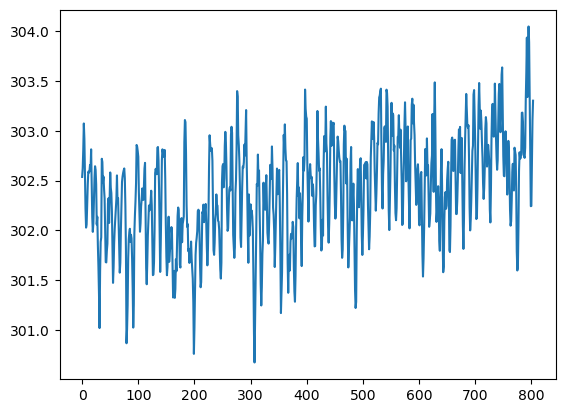

In [3]:
plt.figure()
plt.plot(all_ds['temperature'].sel(lon=180.0, lat=-10.0, depth=5.0, method='nearest'))


## cut the data to post-2005 (i.e., Argo era)

In [4]:
all_ds = all_ds.sel(time=slice("2005-01-01","2024-12-31"))
all_ds = all_ds.drop_vars(["temperature_uncertainty", "salinity_uncertainty", "temperature_observation_weights", "salinity_observation_weights"])
all_ds

<xarray.Dataset> Size: 10GB
Dimensions:      (time: 240, depth: 42, lat: 173, lon: 360, bnds: 2)
Coordinates:
  * depth        (depth) float32 168B 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
  * lat          (lat) float32 692B -83.0 -82.0 -81.0 -80.0 ... 87.0 88.0 89.0
  * lon          (lon) float32 1kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * time         (time) datetime64[ns] 2kB 2005-01-16T12:00:00 ... 2024-12-16...
Dimensions without coordinates: bnds
Data variables:
    temperature  (time, depth, lat, lon) float64 5GB dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    salinity     (time, depth, lat, lon) float64 5GB dask.array<chunksize=(1, 21, 87, 180), meta=np.ndarray>
    time_bnds    (time, bnds) datetime64[ns] 4kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    depth_bnds   (time, depth, bnds) float32 81kB dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
Attributes: (12/22)
    Conventions:            CF-1.0
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    institution:            UK Met Office
    contact:                Rachel Killick - rachel.killick@metoffice.gov.uk
    ...                     ...
    southernmost_latitude:  -90.5
    northernmost_latitude:  89.5
    westernmost_longitude:  0.5
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...

## remove the monthly climatology from the SST

In [ ]:
new_depth = np.arange(5,2001,10)
new_depth_thick = np.arange(0,2001,10)
new_depth_thick[0] = 0; new_depth_thick[-1] = 2000; 
new_depth_thick = np.diff(new_depth_thick)
print(len(new_depth), len(new_depth_thick))

new_depth_thick = new_depth_thick[:, np.newaxis, np.newaxis]
new_depth_thick = np.broadcast_to(new_depth_thick, (200,173,360))

dep_thick = xr.DataArray(
    new_depth_thick,
    dims=["depth", "lat", "lon"],
    coords={"depth": new_depth, "lon":all_ds.coords["lon"].values, "lat":all_ds.coords["lat"].values}
    )


In [ ]:
%%time

for var in all_ds.data_vars:
    print(f"{var} Gb: {all_ds[var].nbytes * 1e-9}")

all_ds = all_ds.compute()


In [ ]:
%%time

temp_lin = all_ds.temperature.where(all_ds.salinity>0.0, other=np.nan).sel(depth=slice(0,2000)).interp(depth=new_depth, method='linear')
salt_lin = all_ds.salinity.where(all_ds.salinity>0.0, other=np.nan).sel(depth=slice(0,2000)).interp(depth=new_depth, method='linear')

temp = all_ds.temperature.where(all_ds.salinity>0.0, other=np.nan).interpolate_na(dim='lon', method='linear').interpolate_na(dim='lat', method='linear').interpolate_na(dim='depth', method='linear')
salt = all_ds.salinity.where(all_ds.salinity>0.0, other=np.nan).interpolate_na(dim='lon', method='linear').interpolate_na(dim='lat', method='linear').interpolate_na(dim='depth', method='linear')

temp = temp.where(~np.isnan(salt),other=0.0).sel(depth=slice(0,2000))
salt = salt.where(~np.isnan(salt),other=0.0).sel(depth=slice(0,2000))

temp_cub = temp.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
salt_cub = salt.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)


In [ ]:
temp_cub

## Calculate density from temperature and salinity

In [ ]:
%%time

rho0_lin = gsw.density.sigma0(salt_lin, temp_lin-273.15)
rho0_cub = gsw.density.sigma0(salt_cub, temp_cub-273.15)

# mask rho0 where there are zeros
rho0_lin = rho0_lin.where(rho0_lin > 0.0, other=np.nan)
rho0_cub = rho0_cub.where(rho0_cub > 0.0, other=np.nan)


## Compute MLD from a density threshold criterion

In [9]:
%%time

def compute_mld(rho_profile, depth, criterion=0.1):
    """
    Compute the mixed layer depth (MLD) for a single vertical column.
    
    Parameters:
      rho_profile : 1D numpy array
          Density profile (kg/m^3) along the depth dimension.
      depth : 1D numpy array
          Depth levels corresponding to the density profile.
      criterion : float, optional
          The density difference criterion (default is 0.1 kg/m^3).
    
    Returns:
      mld : float
          The estimated mixed layer depth. Returns np.nan if the criterion
          is never reached.
    """
    # Calculate the density difference relative to the surface
    drho = rho_profile - rho_profile[0]
    
    # Find the first index where the density difference exceeds the criterion
    idx = np.where(drho >= criterion)[0]
    if len(idx) == 0:
        # If no level meets the criterion, return NaN (or you could choose the deepest level)
        return np.nan
    
    i = idx[0]
    
    # If the criterion is met in the very first level, return the top depth.
    if i == 0:
        return depth[0]
    
    # For a more accurate estimate, linearly interpolate between levels i-1 and i.
    d1, d2 = depth[i-1], depth[i]
    drho1, drho2 = drho[i-1], drho[i]
    
    # Calculate the fractional distance between the two depths where the threshold is met.
    frac = (criterion - drho1) / (drho2 - drho1)
    mld = d1 + frac * (d2 - d1)
    return mld


# Now, use xr.apply_ufunc to apply compute_mld to each vertical column in your dataset.
# Here, we assume that rho is an xarray DataArray with coordinate "depth".
mld = xr.apply_ufunc(
    compute_mld,
    rho0_cub.isel(depth=slice(1,120)),               # the density field
    rho0_cub.isel(depth=slice(1,120))['depth'],      # the depth coordinate (assumed to be 1D)
    input_core_dims=[['depth'], ['depth']],  # indicate that both inputs have a "depth" dimension
    vectorize=True,    # vectorize over lat and lon
    kwargs={'criterion': 0.1},
    output_dtypes=[float]
)



CPU times: user 1min 38s, sys: 819 ms, total: 1min 39s
Wall time: 1min 39s


## Save the MLD variable to netcdf


In [19]:
sst = all_ds['temperature'].isel(depth=0)

mld.name = "mld"
mld.to_netcdf("/g/data/es60/pjb581/SPC/data/EN4_mld_2005-2024.nc")
sst.name = "sst"
sst.to_netcdf("/g/data/es60/pjb581/SPC/data/EN4_sst_2005-2024.nc")


## interpolate to 20ºC isotherm depth

In [ ]:
%%time

def compute_isoz(temp_profile, depth, criterion=20.0):
    """
    Compute the mixed layer depth (MLD) for a single vertical column.
    
    Parameters:
      temp_profile : 1D numpy array
          Temperature profile (degC) along the depth dimension.
      depth : 1D numpy array
          Depth levels corresponding to the density profile.
      criterion : float, optional
          The isotherm temperature (default is 20.0 deg C).
    
    Returns:
      iso : float
          The estimated mixed layer depth. Returns np.nan if the criterion
          is never reached.
    """
    
    # Find the first index where temperature is less than the criterion
    idx = np.where(temp_profile <= criterion)[0]
    if len(idx) == 0:
        # If no level meets the criterion, return NaN (or you could choose the deepest level)
        return np.nan
    
    i = idx[0]
    
    # If the criterion is met in the very first level, return the top depth.
    if i == 0:
        return depth[0]
    
    # For a more accurate estimate, linearly interpolate between levels i-1 and i.
    d1, d2 = depth[i-1], depth[i]
    dtemp1, dtemp2 = temp_profile[i-1], temp_profile[i]
    
    # Calculate the fractional distance between the two depths where the threshold is met.
    frac = (criterion - dtemp1) / (dtemp2 - dtemp1)
    iso = d1 + frac * (d2 - d1)
    return iso


# Now, use xr.apply_ufunc to apply compute_mld to each vertical column in your dataset.
# Here, we assume that rho is an xarray DataArray with coordinate "depth".
z20 = xr.apply_ufunc(
    compute_isoz,
    temp_cub.isel(depth=slice(1,120)),               # the density field
    temp_cub.isel(depth=slice(1,120))['depth'],      # the depth coordinate (assumed to be 1D)
    input_core_dims=[['depth'], ['depth']],  # indicate that both inputs have a "depth" dimension
    vectorize=True,    # vectorize over lat and lon
    kwargs={'criterion': 293.15},
    output_dtypes=[float]
)



## Save the z20 variable to netcdf

In [ ]:
z20.name = "z20"
z20.to_netcdf("/g/data/es60/pjb581/SPC/data/EN4_z20_2005-2024.nc")
